# Dynamic scaLCA - combining dynamic material flow analysis with Life cycle assessment

## 1. Modules and Functions

### 1.1 Modules

In [1]:
import bw2data as bd
import bw2io as bi
from pathlib import Path
import bw2data as bd
import bw2calc as bc
import bw_processing as bwp
import pandas as pd
import numpy as np
import scipy.stats
from os import chdir
import matplotlib.pyplot as plt
from dataclasses import dataclass

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="openpyxl")

### 1.2 Classes

In [2]:
@dataclass
class DataArray:
    product: bd.Node
    process: bd.Node
    array: np.ndarray
    consumption: bool = True

### 1.3 Functions

In [3]:
def multiply_column_by_value(column, value):
    """
    Multiply each element in a pandas Series or array-like column by a specified value.

    Parameters
    ----------
    column : pandas.Series or array-like
        The input column of numeric values to be multiplied.
    
    value : float
        The numeric value to multiply each element of the column by.

    Returns
    -------
    numpy.ndarray
        A numpy array containing the multiplied values.
    """
    new_column = column * value
    return new_column.values


def calculate_remaining_fraction_column(column):
    """
    Calculate the complementary fraction (1 minus each element) for a pandas Series or array-like column.

    Parameters
    ----------
    column : pandas.Series or array-like
        The input column of numeric values, typically between 0 and 1.

    Returns
    -------
    numpy.ndarray
        A numpy array containing the complementary fractions.
    """
    new_column = 1 - column
    return new_column.values
    

def data_obj_for_arrays(arrays: list[DataArray]) -> bwp.Datapackage:
    """
    Create a Brightway2-Py (bwp) Datapackage object from a list of DataArray objects.

    This function takes a list of `DataArray` objects, extracts their data arrays,
    index pairs (product, process), and consumption flags, and compiles them into
    a `bwp.Datapackage` object with a `technosphere_matrix`.

    Parameters
    ----------
    arrays : list of DataArray
        A list of `DataArray` objects, each of which must contain:
        - `.array` (numerical data)
        - `.product.id` and `.process.id` (index pair)
        - `.consumption` (boolean indicating direction)

    Returns
    -------
    bwp.Datapackage
        A datapackage object containing the technosphere matrix populated from the input arrays.

    Raises
    ------
    AssertionError
        If any item in the input list is not a `DataArray` instance.

    Notes
    -----
    - The function vertically stacks the `.array` attributes of all DataArrays.
    - It creates the corresponding `indices_array` with `product.id` and `process.id`.
    - It flips the sign of data if `dc.consumption` is True (handled by `flip_array`).
    """
    # Validate input types
    for dc in arrays:
        assert isinstance(dc, DataArray), "Oops, wrong input type"

    # Stack the data arrays into a single array
    data_array = np.vstack([dc.array for dc in arrays])

    # Extract (product, process) ID tuples
    indices_array = np.array(
        [(dc.product.id, dc.process.id) for dc in arrays], 
        dtype=bwp.INDICES_DTYPE
    )

    # Create a boolean array to determine whether to flip signs
    flip_array = np.array([not dc.consumption for dc in arrays])

    # Create a new datapackage
    dp = bwp.create_datapackage(sequential=True)

    # Add the data to the technosphere matrix of the datapackage
    dp.add_persistent_array(
        matrix="technosphere_matrix",
        indices_array=indices_array,
        data_array=data_array,
        flip_array=flip_array,
    )

    return dp




## 2. Life cycle assessment

### 2.1 Project set-up in Brightway

In [4]:
# Create project name
PROJECT_NAME = "Linking dMFA & LCA"

#Load Ecoinvent database
bi.restore_project_directory(
    fp='/etc/data/ecoinvent-3.10-cutoff-bw25.tar.gz',
    project_name=PROJECT_NAME,
    overwrite_existing=True
)
#Define project in brightway
bd.projects.set_current(PROJECT_NAME)

#Define database
db=bd.Database('ecoinvent-3.10-cutoff')


"""make our own database"""

Restoring project backup archive - this could take a few minutes...
Restored project: Linking dMFA & LCA
12:16:59+0000 [info     ] Applying automatic update: 4.0 database search directories FTS5
12:16:59+0000 [info     ] Reindexing database ecoinvent-3.10-biosphere
12:16:59+0000 [info     ] Reindexing database ecoinvent-3.10-cutoff


'make our own database'

### 2.2 Primary & Secondary steel production

In [5]:
# selecting ecoinvent processes
primary_steel_production = bd.get_node(
    name='steel production, electric, chromium steel 18/8',
    location = 'RER').copy(name = 'primary steel production', database=db.name)

secondary_steel_production = bd.get_node(
    name='steel production, electric, chromium steel 18/8',
    location = 'RER').copy(name = 'secondary steel production', database=db.name)

ecoinvent_steel_scrap = bd.get_node(name='market for scrap steel', location = 'Europe without Switzerland')

ecoinvent_iron_ore = bd.get_node(name='market for iron ore concentrate', location = 'GLO')

In [6]:
### creating new output product for recycling process
primary_steel = db.new_node(
    name='primary steel',
    code = 'primary steel',
    unit="kilogram",
    location = "RER",
    type=bd.labels.product_node_default,
)
primary_steel.save()

#deleting old output in primary production
for exc in primary_steel_production.production():
    exc.delete()

#adding the secondary steel output
primary_steel_production.new_edge(
    input=primary_steel,
    amount=1,
    type=bd.labels.production_edge_default
).save()

#checking that the output was replaced
print(list(primary_steel_production.production()))

#changing material inputs in primary steel production (replace iron scrap with iron ore)
iron_scrap_input_primary = list(primary_steel_production.edges())[13]
iron_ore_amount = iron_scrap_input_primary['amount']
iron_scrap_input_primary.delete() #new inflow is added in cell below
iron_scrap_input_primary.save()

#adding iron ore as inflow for primary steel production
primary_steel_production.new_edge(
    amount = iron_ore_amount, #calculated in cell above
    type=bd.labels.consumption_edge_default,
    input=ecoinvent_iron_ore
).save()

[Exchange: 1 kilogram 'primary steel' (kilogram, RER, None) to 'primary steel production' (kilogram, RER, None)>]


In [7]:
### creating new output product for recycling process
secondary_steel = db.new_node(
    name='secondary steel',
    code = 'secondary steel',
    unit="kilogram",
    location = "RER",
    type=bd.labels.product_node_default,
)
secondary_steel.save()

In [8]:
#deleting old output
for exc in secondary_steel_production.production():
    exc.delete()

#adding the secondary steel output
secondary_steel_production.new_edge(
    input=secondary_steel,
    amount=1,
    type=bd.labels.production_edge_default
).save()

#checking that the output was replaced
list(secondary_steel_production.production())

[Exchange: 1 kilogram 'secondary steel' (kilogram, RER, None) to 'secondary steel production' (kilogram, RER, None)>]

In [9]:
#reducing the iron, nickel & chromium inflows to 40%
chromium_input = list(secondary_steel_production.edges())[9]
nickel_input = list(secondary_steel_production.edges())[10]
iron_scrap_input = list(secondary_steel_production.edges())[13]

steel_scrap_amount = (nickel_input['amount'] + chromium_input['amount'] + iron_scrap_input['amount']) * 0.6

nickel_input['amount'] = nickel_input['amount'] * 0.4
chromium_input['amount'] = chromium_input['amount'] * 0.4
iron_scrap_input['amount'] = iron_scrap_input['amount'] * 0.4

chromium_input.save()
nickel_input.save()
iron_scrap_input.save()

In [10]:
#adding 60% of raw material inputs as scrap metal
secondary_steel_production.new_edge(
    amount = steel_scrap_amount, #calculated in cell above
    type=bd.labels.consumption_edge_default,
    input=ecoinvent_steel_scrap
).save()

In [11]:
list(secondary_steel_production.production())

[Exchange: 1 kilogram 'secondary steel' (kilogram, RER, None) to 'secondary steel production' (kilogram, RER, None)>]

### 2.3 Kettle production

#### 2.3.1 Product and process definition

In [12]:
ecoinvent_kettle_process = bd.get_node(name='electric kettle production', location = 'GLO')
kettle_production = ecoinvent_kettle_process.copy(name='kettle production')

In [13]:
delete_targets = {
    'market for chromium',
    'market for nickel, class 1',
    'market for steel, low-alloyed, hot rolled', 
}

for exc in kettle_production.edges():
    input_name = exc.input['name']
    
    if input_name in delete_targets and "waste" not in input_name.lower():
        print(f"Deleting: {input_name}, amount={exc['amount']}, location={exc.input['location']}")
        exc.delete()

Deleting: market for chromium, amount=0.017734, location=GLO
Deleting: market for nickel, class 1, amount=0.070938, location=GLO
Deleting: market for steel, low-alloyed, hot rolled, amount=0.547818, location=GLO


#### 2.3.2 Technosphere flows kettle production

In [14]:
kettle = db.new_node(
    name='kettle',
    unit="number",
    location = "IE",
    type=bd.labels.product_node_default,
)
kettle.save()

In [15]:
#deleting old output
for exc in kettle_production.production():
    exc.delete()

#adding the secondary steel output
kettle_production.new_edge(
    input=kettle,
    amount=1,
    type=bd.labels.production_edge_default
).save()

#checking that the output was replaced
list(kettle_production.production())

[Exchange: 1 number 'kettle' (number, IE, None) to 'kettle production' (unit, GLO, None)>]

In [16]:
kettle_production.new_edge(
    amount=42, # Dummy value 
    type=bd.labels.consumption_edge_default,
    input=secondary_steel
).save()

kettle_production.new_edge(
    amount=42, # Dummy value 
    type=bd.labels.consumption_edge_default,
    input=primary_steel
).save()

### 2.4 Use phase

In [17]:
kettle_service = db.new_node(
    name='kettle service per year',
    unit='kWh per year',
    type=bd.labels.product_node_default,
)

using_kettle = db.new_node(
    name='using kettle',
    location='IE',
    type=bd.labels.process_node_default,
)

kettle_service.save()
using_kettle.save()

In [18]:
using_kettle.new_edge(
    amount=1,
    input=kettle_service,
    type=bd.labels.production_edge_default,
).save()

In [19]:
electric_mix_IE = bd.get_node(
    name='market for electricity, medium voltage', 
    location='IE',
)

In [20]:
using_kettle.new_edge(
    amount=167, #value is average yearly energy used per kettle Durand et al. 2022
    type=bd.labels.consumption_edge_default,
    input=electric_mix_IE
).save()

### 2.5 End of Life

In [21]:
kettle_treated = db.new_node(
    name='kettle waste treated',
    unit='number',
    type=bd.labels.product_node_default,
)

treating_kettle = db.new_node(
    name='kettle waste treatment',
    location='IE',
    type=bd.labels.process_node_default,
)

kettle_treated.save()
treating_kettle.save()

In [22]:
treating_kettle.new_edge(
    amount=1,
    input=kettle_treated,
    type=bd.labels.production_edge_default,
).save()

In [23]:
waste_metal = bd.get_node(
    name='market for metal part of electronics scrap, in copper, anode', 
)

waste_plastic = bd.get_node(
    name='market for waste plastic, mixture',
    location='IE',
)

In [24]:
treating_kettle.new_edge(
    amount=-27.349,
    type=bd.labels.consumption_edge_default,
    input=waste_metal
).save()

treating_kettle.new_edge(
    amount=-839.726,
    type=bd.labels.consumption_edge_default,
    input=waste_plastic
).save()

## 3. Dynamic material flow analysis

### 3.1 Load and organise data

In [25]:
# Load input data, inflow-driven model, Timeseries represents Irish purchases of 'hot water electronics' from 1980-2022
stock_flow_timeseries = pd.read_excel(r'WEEE_generated_Tool_IE.xlsm', sheet_name='POM')

# Extract the relevant rows and columns
stock_flow_timeseries = stock_flow_timeseries.iloc[20,6:-9]
stock_flow_timeseries = stock_flow_timeseries.to_frame()

#Define timesteps that are covered in the dataset
timesteps = range(1980,2023)

#Define timeseries dataset including the associated yeart
stock_flow_timeseries['year'] = timesteps
stock_flow_timeseries = stock_flow_timeseries.iloc[1:,:]
stock_flow_timeseries = stock_flow_timeseries.set_index('year')
stock_flow_timeseries = stock_flow_timeseries.rename(columns={20:'inflow'})

### 3.2 Define Lifetime curve

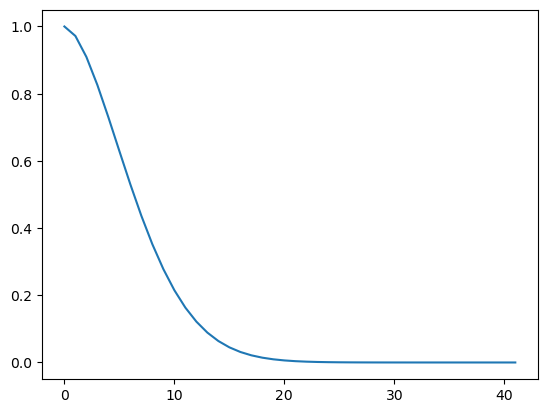

In [26]:
#Define timesteps
time_max = stock_flow_timeseries.shape[0]
timesteps = np.arange(0, time_max)

# Weibull distributed survival curve representative for the Netherlands, Belgium and France (no data available for Ireland)
curve_shape = 1.73
curve_scale = 7.8
curve_surv = scipy.stats.weibull_min.sf(timesteps, curve_shape, 0, curve_scale)

#Visualise the result
plt.plot(curve_surv)

#Define data as float to align with later usage
curve_surv = curve_surv.astype(float)

### 3.3 Initiate normalized survival curve matrix

In [27]:
# create survival curve matrix with placeholder zeros
curve_surv_matrix = pd.DataFrame(0.0, index=timesteps, columns=timesteps)

# populate the survival curve matrix with shifted curves, column by column using slices
for time in timesteps:
    curve_surv_matrix.loc[time:, time] = curve_surv[0:time_max - time]

### 3.4 Populate survival curve matrix with inflow values

In [28]:
# create survival matrix with placeholder zeros
cohort_surv_matrix = pd.DataFrame(0.0, index=timesteps, columns=timesteps)

# multiply the inflow times the shifted curves to get the cohorts' behavior over time

for time in timesteps:
    cohort_surv_matrix.loc[:, time] = curve_surv_matrix.loc[:, time] * stock_flow_timeseries['inflow'].iloc[time]

# set row index to years instead of timesteps
cohort_surv_matrix.index = stock_flow_timeseries.index



### 3.5 Calculate stock, net addition to stock (NAS) and Outflow of products

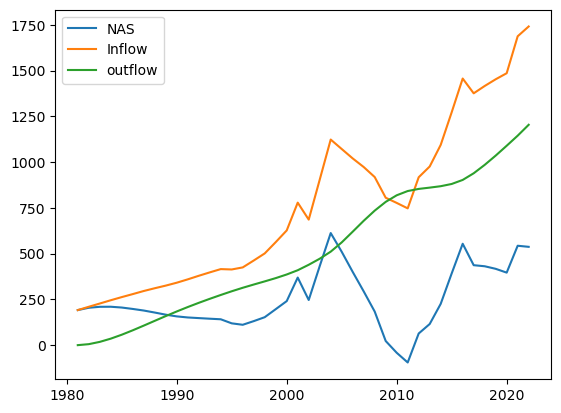

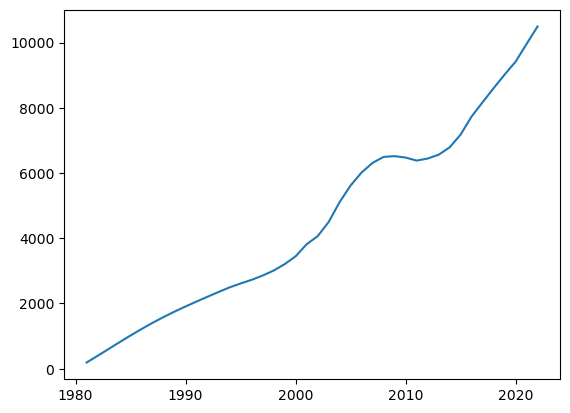

In [29]:
# calculate flows & stocks using the cohort_surv_matrix
stock_flow_timeseries['stock'] = cohort_surv_matrix.sum(axis=1)
stock_flow_timeseries['nas'] = np.diff(stock_flow_timeseries['stock'], prepend=0)  # prepending 0 assumes no initial stock
stock_flow_timeseries['outflow'] = stock_flow_timeseries['inflow'] - stock_flow_timeseries['nas']

#Visualize calculated flows and stocks
plt.plot(stock_flow_timeseries.index,stock_flow_timeseries['nas'], label = 'NAS')
plt.plot(stock_flow_timeseries.index,stock_flow_timeseries['inflow'], label = 'Inflow')
plt.plot(stock_flow_timeseries.index,stock_flow_timeseries['outflow'], label = 'outflow')
plt.legend()
plt.show()
plt.close()
plt.plot(stock_flow_timeseries.index,stock_flow_timeseries['stock'], label = 'stock')

### 3.6 Calculate material content in Inflow, NAS, Outflow and stock

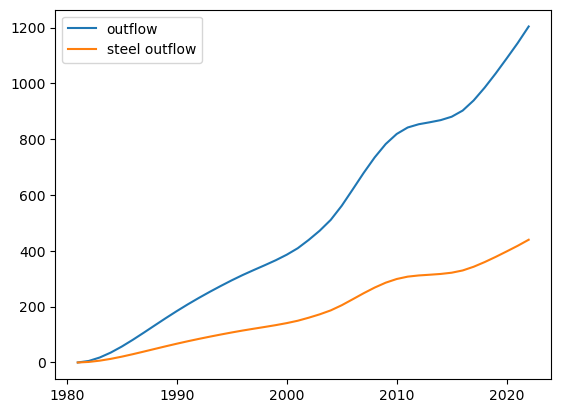

In [30]:
#Definde steel intensity as function of the inputs to the kettle process production
steel_intensity = 0.3653 #Because significant digits matter

#Calculate material content
steel_stock_flow_timeseries = stock_flow_timeseries*steel_intensity

# Visualize the comparison of the total inflow and the material contents in inflow
plt.plot(stock_flow_timeseries.index,stock_flow_timeseries['outflow'], label = 'outflow')
plt.plot(steel_stock_flow_timeseries.index,steel_stock_flow_timeseries['outflow'], label = 'steel outflow')
plt.legend()
plt.show()
plt.close()

### 3.7 Calculate secondary material availablility

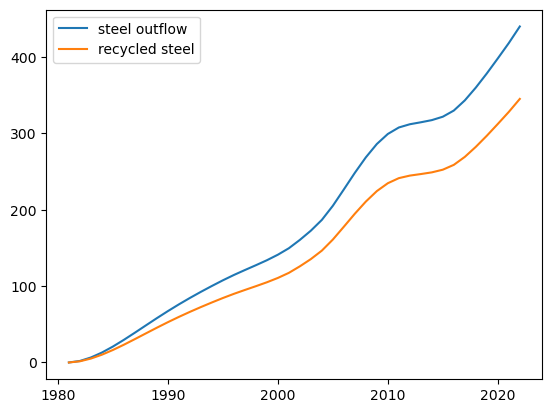

In [31]:
# Define static efficiency of steel recycling
steel_recycle_efficiency = 0.784444 #Because significant digits matter

# Calculate the secondary material availability of steel
secondary_steel_stock_flow_timeseries = steel_stock_flow_timeseries*steel_recycle_efficiency

#Visualise the steel outflow vs. the secondary steel outflow
plt.plot(steel_stock_flow_timeseries.index,steel_stock_flow_timeseries['outflow'], label = 'steel outflow')
plt.plot(secondary_steel_stock_flow_timeseries.index,secondary_steel_stock_flow_timeseries['outflow'], label = 'recycled steel')
plt.legend()
plt.show()
plt.close()

#Calculate the relative share of secondary material in the inflow for steel
secondary_steel_share = secondary_steel_stock_flow_timeseries['outflow']/steel_stock_flow_timeseries['inflow']



## 4. Integrate the dMFA results with the LCA

### 4.1 Extract steel mass from inventory

In [32]:
#define primary steel mass
""" Add function to extract this from the inventory"""
steel_primary_mass = 0.546246 #in kg from Ecoinvent

### 4.2 Calculate primary and secondary steel values and save in an array

In [33]:
#Create df to store secondary steel values
steel_df = pd.DataFrame()
steel_df['years'] = stock_flow_timeseries.index

#Calculate secondary and primary steel share
steel_df['secondary steel share'] = secondary_steel_share.values
steel_df['primary steel share'] = calculate_remaining_fraction_column(steel_df['secondary steel share'])

#Call function to calculate new material composition and add to df
steel_df['updated secondary steel share'] = multiply_column_by_value(steel_df['secondary steel share'],steel_primary_mass)
steel_df['updated primary steel share'] = multiply_column_by_value(steel_df['primary steel share'],steel_primary_mass)


#Save in an array
primary_steel_values = DataArray(
    product=kettle,
    process=kettle_production,
    array=steel_df['updated primary steel share'].values
)

#Save in an array
secondary_steel_values = DataArray(
    product=kettle,
    process=kettle_production,
    array=steel_df['updated secondary steel share'].values  
)


### 4.3 Run function to create a Brightway2-Py Datapackage object from a list of DataArray objects.

In [34]:
dp = data_obj_for_arrays([
    primary_steel_values,
    secondary_steel_values,
])

## 4.4 LCA method selection

In [43]:
# methods = [
#     method for method in bd.methods 
#     if 'ipcc 2021' in method[0].lower() 
#     and method[1] == 'climate change'
#     and 'gwp100' in method[2].lower()
#     and 'LT' not in method[2]
# ]
# methods


[[('IPCC 2021', 'climate change', 'global warming potential (GWP100)')]]

In [46]:
methods = ('IPCC 2021', 'climate change', 'global warming potential (GWP100)')

In [47]:
multi_config = {
    "impact_categories": methods
}

### 4.4 Calculate LCIA of Production, Use Phase and EoL

In [51]:


ipcc = ('IPCC 2021', 'climate change', 'global warming potential (GWP100)')



In [52]:
functional_unit, data_objs, _ = bd.prepare_lca_inputs({db.get(kettle_service['code']).id: 1}, method=ipcc)

In [56]:
lca = bc.LCA(functional_unit, data_objs = data_objs)
lca.lci()
lca.lcia()
lca.score

TypeError: 'float' object is not callable

In [48]:
functional_unit_use = {
    "Use of a kettle for a year": {db.get(kettle_service['code']).id: 1},
}
use_data_objs = bd.get_multilca_data_objs(
    functional_units=functional_unit_use, 
    method_config=multi_config
)

ValueError: Impact category (`Method`) IPCC 2021 not in this project

In [40]:
use_lca = bc.MultiLCA(demands=functional_unit_use, method_config=multi_config, data_objs=use_data_objs)
use_lca.lci()
use_lca.lcia()
use_lca.scores

TypeError: 'dict' object is not callable

### 4.5 Calculate the LCIA of production

In [ ]:
#Define impact category method
ipcc = ('IPCC 2021', 'climate change', 'global warming potential (GWP100)')

#Define functional unit for production phase
functional_unit, data_objs, _ = bd.prepare_lca_inputs({kettle: 1}, remapping=False,method=ipcc)

#Set-up LCA
lca = bc.LCA(functional_unit, data_objs = data_objs + [dp], use_arrays=True)

#Calculate LCI for the production phase
lca.lci()

#Calculate LCIA for production phase
lca.lcia()

production_LCIA ={}
for value in steel_df['year'].unique():
    #so it doesnt go to the value of the next year already
    LCA.keep_first_iteration()
    #Add the LCIA of the production phase to the next year
    production_LCIA[year] = next(lca)

In [ ]:
for value in np.array(secondary_steel_share):
    materials = update_material_composition(value)
    primary_input = list(kettle_production.technosphere())[0]
    secondary_input = list(kettle_production.technosphere())[1]
    
    primary_input['amount'] = materials['slt1']
    primary_input.save()

    secondary_input['amount'] = materials['slt2']
    secondary_input.save()
    

    functional_unit, data_objs, _ = bd.prepare_lca_inputs({kettle: 1}, remapping=False)
    lca = bc.LCA(demand=functional_unit, data_objs=data_objs)
    lca.lci()
    lca.lcia()
    


In [ ]:
    
    primary_input['amount'] = materials['slt1']
    primary_input.save()

    secondary_input['amount'] = materials['slt2']
    secondary_input.save()

    functional_unit, data_objs, _ = bd.prepare_lca_inputs({kettle: 1}, remapping=False)
    lca = bc.LCA(demand=functional_unit, data_objs=data_objs)
    lca.lci()
    lca.inventory[lca.dicts.biosphere[co2.id], :].sum()
    lca.inventory[lca.dicts.biosphere[co2.id], :].sum()

In [ ]:
secondary_steel_share_dict

In [ ]:
my_edge['<some_key>'] = "<some_new_value>"
my_edge.save()


lca = bc.LCA(demand=functional_unit, data_objs=data_objs)
lca.lci()
lca.inventory[lca.dicts.biosphere[co2.id], :].sum()

In [ ]:
primary_input = list(kettle_production.technosphere())[0]
primary_input

In [ ]:
secondary_input = list(kettle_production.technosphere())[1]
secondary_input

In [ ]:
primary_input['amount'] = 0.5
primary_input.save()
primary_input

In [ ]:
secondary_input['amount'] = 0.1
secondary_input.save()
secondary_input

In [ ]:
list(kettle_production.technosphere())

### Old environmental calculations

In [ ]:
functional_unit, data_objs, _ = bd.prepare_lca_inputs({kettle: 1}, remapping=False)